In [1]:
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import datetime


In [2]:
# Downloading historical data for Tesla (TSLA)
tesla_data = yf.download("TSLA", start="2010-01-01", end="2024-12-31")
print("Tesla Stock Data:")
tesla_data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Tesla Stock Data:


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [4]:
import zipfile
import os

# Unzip the uploaded file
zip_path = "/content/archive (4).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/tesla_data")  # Extract to a folder


In [5]:
# List all files in the extracted folder
os.listdir("/content/tesla_data")


['tesla_stocks.csv']

In [17]:
from google.colab import files
uploaded = files.upload()


Saving archive (4).zip to archive (4) (1).zip


In [18]:
import zipfile
import os

# Unzip the uploaded file
with zipfile.ZipFile("archive (4).zip", 'r') as zip_ref:
    zip_ref.extractall("tesla_data")  # Folder name for extraction


In [19]:
# List files to confirm name
os.listdir("tesla_data")


['tesla_stocks.csv']

In [21]:
df = pd.read_csv("tesla_data/tesla_stocks.csv")
df.head()


,Date,Close/Last,Volume,Open,High,Low
0,12/06/2024,$389.22,81455830,$377.42,$389.49,$370.80
1,12/05/2024,$369.49,81403570,$359.87,$375.43,$359.50
2,12/04/2024,$357.93,50810870,$353.00,$358.10,$348.60
3,12/03/2024,$351.42,58267200,$351.80,$355.69,$348.20
4,12/02/2024,$357.09,77986480,$352.38,$360.00,$351.1501


In [23]:
# Load data (already done)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Rename for consistency
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Only keep 'Close' prices
data = df[['Close']]


In [25]:
# Remove '$' and convert to float
df['Close'] = df['Close'].replace({'\$': ''}, regex=True).astype(float)


In [26]:
cols_to_clean = ['Close', 'Open', 'High', 'Low']
for col in cols_to_clean:
    df[col] = df[col].replace({'\$': ''}, regex=True).astype(float)


In [27]:
data = df[['Close']]  # Or any other column you're using
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [28]:
sequence_len = 60
x, y = [], []

for i in range(sequence_len, len(scaled_data)):
    x.append(scaled_data[i-sequence_len:i, 0])
    y.append(scaled_data[i, 0])

x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))


In [30]:
from keras.layers import Dense, LSTM, Dropout


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [34]:
# Create the DataFrame of predicted vs actual values
windowed_df = pd.DataFrame({
    'Target Date': df['Date'][60:],  # 60 is your window size
    'Target': scaler.inverse_transform(y.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(model.predict(x)).flatten()
})


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


In [36]:
windowed_df.head()


,Target Date,Target,Predicted
60,2015-03-06,12.9253,9.119971
61,2015-03-09,12.7253,9.126652
62,2015-03-10,12.6880,9.135468
63,2015-03-11,12.9160,9.145160
64,2015-03-12,12.7380,9.153314


In [37]:
data = df[['Close']].values  # Using only 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
x = []
y = []
window_size = 60

for i in range(window_size, len(scaled_data)):
    x.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

x = np.array(x)
y = np.array(y)

# Reshape input for LSTM [samples, time_steps, features]
x = np.reshape(x, (x.shape[0], x.shape[1], 1))


In [38]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x, y, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0276
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0034
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0023
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0025
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0023
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0021
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0020
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0018
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0017
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0017


In [39]:
predictions = model.predict(x)
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y.reshape(-1, 1))


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


In [40]:
windowed_df = pd.DataFrame({
    'Target Date': df['Date'][window_size:].reset_index(drop=True),
    'Target': real_prices.flatten(),
    'Predicted': predicted_prices.flatten()
})

windowed_df.head()


,Target Date,Target,Predicted
0,2015-03-06,12.9253,12.875180
1,2015-03-09,12.7253,12.787925
2,2015-03-10,12.6880,12.674216
3,2015-03-11,12.9160,12.549153
4,2015-03-12,12.7380,12.444360


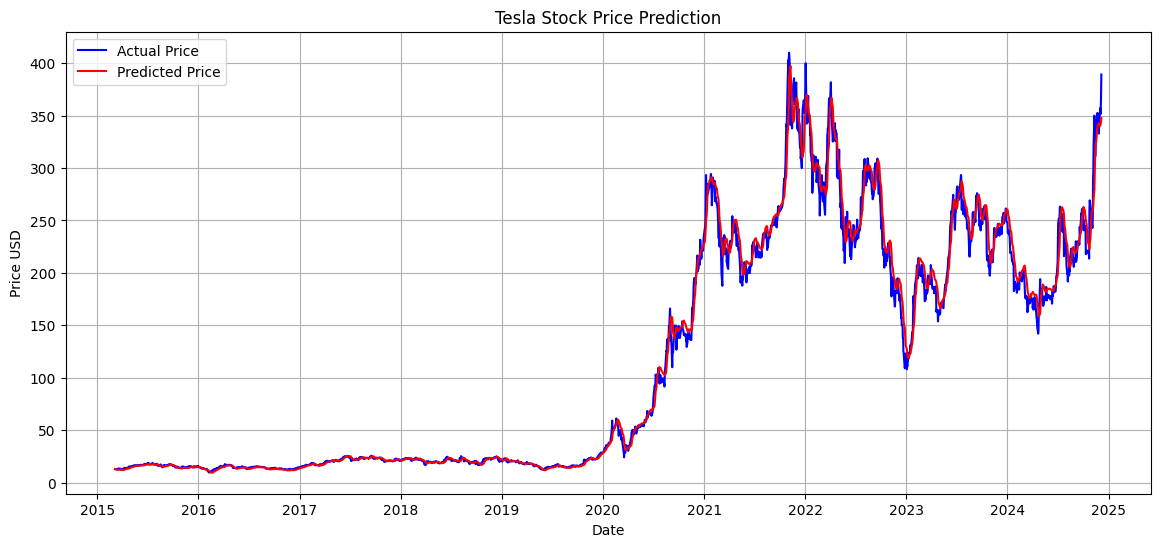

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(windowed_df['Target Date'], windowed_df['Target'], color='blue', label='Actual Price')
plt.plot(windowed_df['Target Date'], windowed_df['Predicted'], color='red', label='Predicted Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for distribution plot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# ... (your previous code for data loading, preprocessing, and model training) ...

# Predictions
predictions = model.predict(x)
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Create DataFrame for plotting
windowed_df = pd.DataFrame({
    'Target Date': df['Date'][window_size:].reset_index(drop=True),
    'Target': real_prices.flatten(),
    'Predicted': predicted_prices.flatten()
})

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


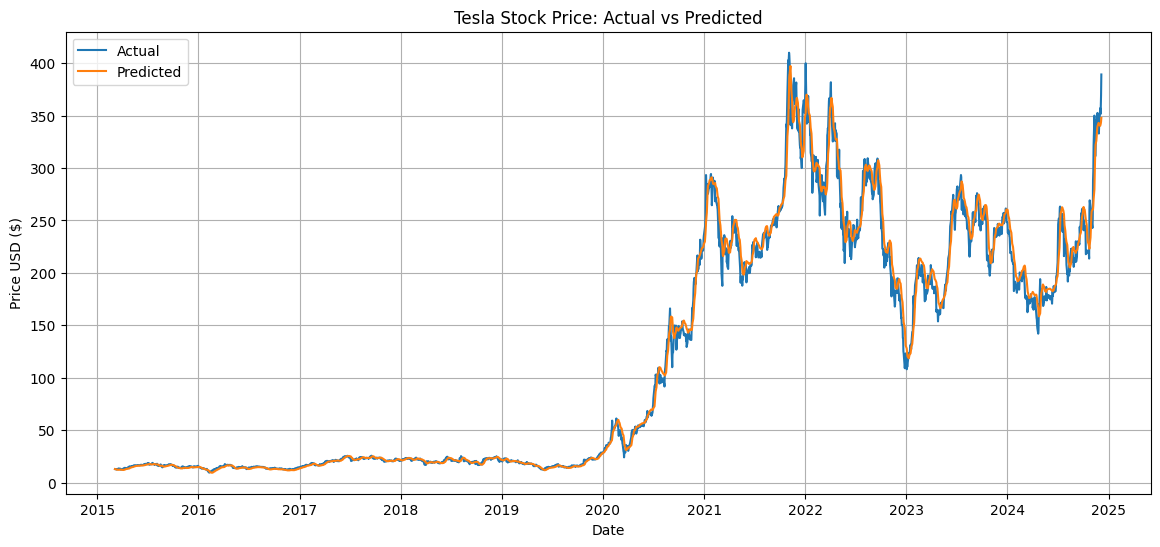

In [45]:
# Plotting
# 1. Actual vs Predicted (Full)
plt.figure(figsize=(14, 6))
plt.plot(windowed_df['Target Date'], windowed_df['Target'], label='Actual')
plt.plot(windowed_df['Target Date'], windowed_df['Predicted'], label='Predicted')
plt.title('Tesla Stock Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.legend()
plt.grid(True)
plt.show()


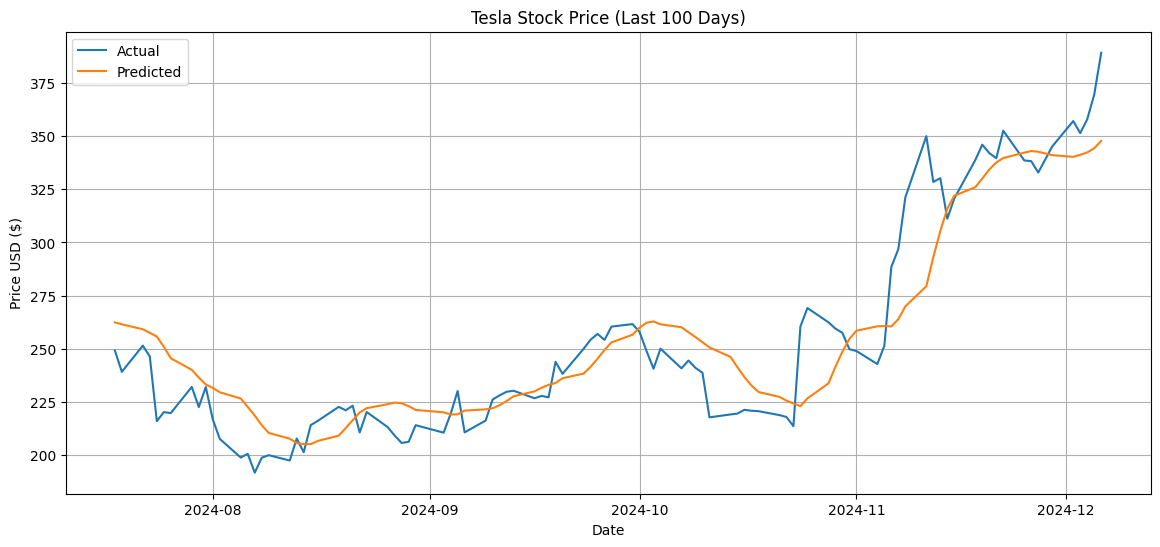

In [46]:
# 2. Actual vs Predicted (Last 100 Days)
plt.figure(figsize=(14, 6))
plt.plot(windowed_df['Target Date'][-100:], windowed_df['Target'][-100:], label='Actual')
plt.plot(windowed_df['Target Date'][-100:], windowed_df['Predicted'][-100:], label='Predicted')
plt.title('Tesla Stock Price (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.legend()
plt.grid(True)
plt.show()


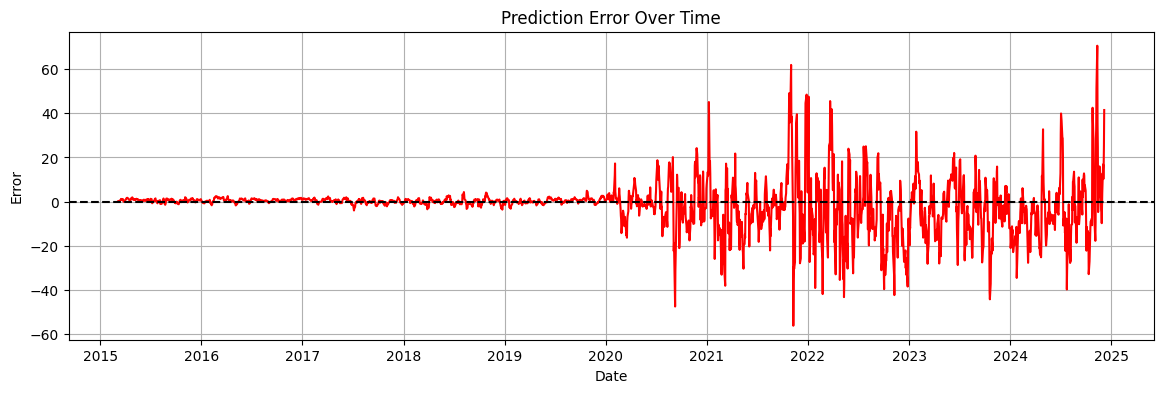

In [47]:
# 3. Residuals
windowed_df['Error'] = windowed_df['Target'] - windowed_df['Predicted']
plt.figure(figsize=(14, 4))
plt.plot(windowed_df['Target Date'], windowed_df['Error'], label='Error', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True)
plt.show()

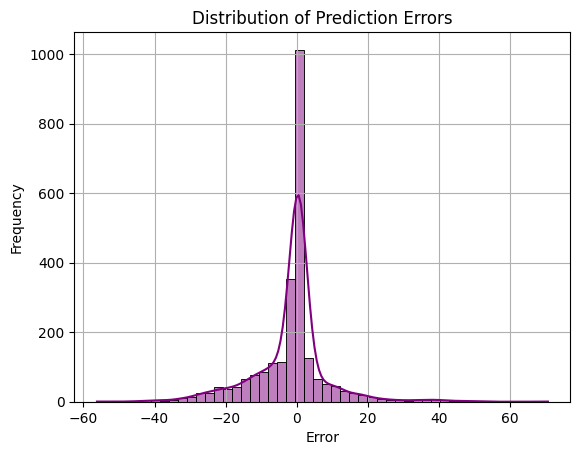

In [48]:
# 4. Distribution of Prediction Error
sns.histplot(windowed_df['Error'], bins=50, kde=True, color='purple')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math  # Import math for sqrt

# ... (your previous code for data loading, preprocessing, model training, and plotting) ...

# Calculate RMSE and MAE
rmse = math.sqrt(mean_squared_error(windowed_df['Target'], windowed_df['Predicted']))
mae = mean_absolute_error(windowed_df['Target'], windowed_df['Predicted'])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 10.71
MAE: 6.18


In [52]:
windowed_df.to_csv("tesla_predictions.csv", index=False)
files.download("tesla_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>